In [1]:
!pip install sklearn
!pip install dash
!pip install dash_bootstrap_components

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, log, exp
import plotly.express as px

Importação dos resultados do ensaio

In [3]:
df = pd.read_csv('modelo.xls', sep=';')

Calculo dos resultados

In [4]:
e_list = list()
sd_list = list()
mr_list = list()
oct_list = list()
for i in df.index:
    e = (float(df['LVDT-A (mm)'][i])+float(df['LVDT-B (mm)'][i]))/2/200
    sd =  (float(df['Carga (kgf)'][i])*9.81)/(100**2*pi/4)
    mr = sd/e
    oct = (sd+3*float(df['s3 (Mpa)'][i]))
    e_list.append(e)
    sd_list.append(sd)
    mr_list.append(mr)
    oct_list.append(oct)
df['e'] = e_list
df['sd (Mpa)'] = sd_list
df['oct (mpa)'] = oct_list
df['MR (Mpa)'] = mr_list


In [5]:
df_result = df.copy()

Vizualização dos resultados

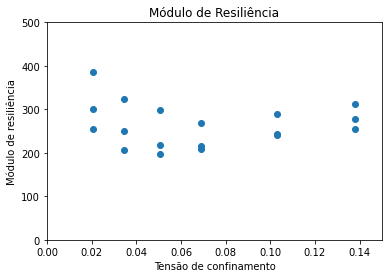

In [6]:
fig_s3 = plt.figure()
plt.scatter(df.filter(items=['s3 (Mpa)']), df.filter(items=['MR (Mpa)']), vmin=100)
#plt.plot(x, regressor.predict(x), color='red')
plt.title('Módulo de Resiliência')
plt.xlabel('Tensão de confinamento')
plt.ylabel('Módulo de resiliência')
plt.xlim(0,0.15)
plt.ylim(0,500)
fig_s3_px = px.scatter(df, x='s3 (Mpa)', y='MR (Mpa)', labels={'MR (Mpa)':'MR (Mpa)'}, log_y=True, title='Módulo de resiliêcia x Tensão de Confinamento')

Preparação para regressão potêncial

In [7]:
#transformação dos parâmetros de entrada para a base ln
ln_mr_list = list()
ln_e_list = list()
ln_s3_list = list()
ln_sd_list = list()
ln_oct_list = list()
for i in df.index:
    ln_mr = log(float(df['MR (Mpa)'][i]))
    ln_e = log(float(df['e'][i]))
    ln_s3 = log(float(df['s3 (Mpa)'][i]))
    ln_sd = log(float(df['sd (Mpa)'][i]))
    ln_oct = log(float(df['oct (mpa)'][i]))
    ln_mr_list.append(ln_mr)
    ln_e_list.append(ln_e)
    ln_s3_list.append(ln_s3)
    ln_sd_list.append(ln_sd)
    ln_oct_list.append(ln_oct)
df['ln_mr'] = ln_mr_list
df['ln_e'] = ln_e_list
df['ln_s3'] = ln_s3_list
df['ln_sd'] = ln_sd_list
df['ln_oct'] = ln_oct_list

In [8]:
#regressão linear dos parâmetro na base ln
y_e = df.iloc[:, 9].values
y_mr = df.iloc[:, 8].values

In [9]:
x_s3 = df.iloc[:, 10].values
x_s3 = x_s3.reshape(-1,1)
x_sd = df.iloc[:, 11].values
x_sd = x_sd.reshape(-1,1)
x_oct = df.iloc[:, 12].values
x_oct = x_oct.reshape(-1,1)
x_comp = df.iloc[:, 10:12].values

In [10]:
from sklearn.linear_model import LinearRegression
regressor_s3 = LinearRegression()
regressor_sd = LinearRegression()
regressor_oct = LinearRegression()
regressor_comp = LinearRegression()
regressor_s3.fit(x_s3, y_mr)
regressor_sd.fit(x_sd, y_e)
regressor_oct.fit(x_oct, y_mr)
regressor_comp.fit(x_comp, y_e)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Regressão com k3 e k4 iguais a zero

In [11]:
k1_s3 = regressor_s3.intercept_
k2 = regressor_s3.coef_[0]

In [12]:
print(f'Interseção:{k1_s3}, Variável X1:{k2}')

Interseção:5.425703531844281, Variável X1:-0.04696997295331014


Regressão com k2 e k4 iguais a zero

In [13]:
k1_sd = regressor_sd.intercept_
k3 = regressor_sd.coef_[0]

In [14]:
print(f'Interseção:{k1_sd}, Variável X1:{k3}')

Interseção:-5.260094063315589, Variável X1:1.1339580636220585


Regressão com k2 e k3 iguais a zero

In [15]:
k1_oct = regressor_oct.intercept_
k4 = regressor_oct.coef_[0]

In [16]:
print(f'Interseção:{k1_oct}, Variável X1:{k4}')


Interseção:5.43989427753686, Variável X1:-0.09565027404390317


Regressão do modelo composto com k4 igual a zero

In [17]:
k1_comp = regressor_comp.intercept_
k2_comp = regressor_comp.coef_[0]
k3_comp = regressor_comp.coef_[1]

In [18]:
print(f'Interseção:{k1_comp}, Variável X1:{k2_comp}, Variável X2:{k3_comp}')

Interseção:-5.582096317776629, Variável X1:-0.24191591364873088, Variável X2:1.2991835658162438


Tranformação para parâmetros potênciais

In [19]:
#modelo dependente da tensão de confinamento
K1_s3 = float(exp(k1_s3))
K2 = k2

In [20]:
eq_s3 = (f'MR = {K1_s3:.0f}*s3^{K2:.4}')
print(eq_s3)

MR = 227*s3^-0.04697


In [21]:
score_s3 = regressor_s3.score(x_s3, y_mr)
print(f'R² = {score_s3:.2}')

R² = 0.03


In [22]:
#modelo dependente da tensão desvio
K1_sd = 1/exp(k1_sd)
K3 = 1-k3

In [23]:
eq_sd = (f'MR = {K1_sd:.0f}*sd^{K3:.4}')
print(eq_sd)

MR = 192*sd^-0.134


In [24]:
score_sd = regressor_sd.score(x_sd, y_e)
print(f'R² = {score_sd:.2}')

R² = 0.97


In [25]:
#modelo dependente do invariante de tensões
K1_oct = exp(k1_oct)
K4 = k4

In [26]:
eq_oct = (f'MR = {K1_oct:.0f}*oct^{K4:.4}')
print(eq_oct)

MR = 230*oct^-0.09565


In [27]:
score_oct = regressor_oct.score(x_oct, y_mr)
print(f'R² = {score_oct:.2}')

R² = 0.13


In [28]:
#modelo composto
K1_comp = 1/exp(k1_comp)
K2_comp = -k2_comp
K3_comp = 1-k3_comp

In [29]:
eq_comp = (f'MR = {K1_comp:.0f}*s3^{K2_comp:.4}*sd^{K3_comp:.4}')
print(eq_comp)

MR = 266*s3^0.2419*sd^-0.2992


In [30]:
score_comp = regressor_comp.score(x_comp, y_e)
print(f'R² = {score_comp:.2}')

R² = 0.98


Previsões de MR

In [31]:
mr_s3_list = list()
mr_sd_list = list()
mr_oct_list = list()
mr_comp_list = list()
for i in df.index:
    mr_s3_cal = K1_s3*(float(df['s3 (Mpa)'][i]))**K2
    mr_sd_cal = K1_sd*(float(df['sd (Mpa)'][i]))**K3
    mr_oct_cal = K1_oct*(float(df['oct (mpa)'][i]))**K4
    mr_comp_cal = K1_comp*((float(df['s3 (Mpa)'][i]))**K2_comp)*((float(df['sd (Mpa)'][i]))**K3_comp)
    #print(mr_s3_cal, mr_sd_cal, mr_oct_cal, mr_comp_cal)
    mr_s3_list.append(mr_s3_cal)
    mr_sd_list.append(mr_sd_cal)
    mr_oct_list.append(mr_oct_cal)
    mr_comp_list.append(mr_comp_cal)       
df['mr_s3_cal'] = mr_s3_list
df['mr_sd_cal'] = mr_sd_list
df['mr_oct_cal'] = mr_oct_list
df['mr_comp_cal'] = mr_comp_list

In [32]:
df

,s3 (Mpa),Carga (kgf),LVDT-A (mm),LVDT-B (mm),e,sd (Mpa),oct (mpa),MR (Mpa),ln_mr,ln_e,ln_s3,ln_sd,ln_oct,mr_s3_cal,mr_sd_cal,mr_oct_cal,mr_comp_cal
0,0.0207,17.88,0.011142,0.012061,0.000058,0.022333,0.084433,385.001562,5.953247,-9.754938,-3.877622,-3.801691,-2.471797,272.553606,320.333041,291.874046,324.226186
1,0.0207,36.50,0.028317,0.032436,0.000152,0.045590,0.107690,300.167905,5.704342,-8.792403,-3.877622,-3.088061,-2.228496,272.553606,291.128510,285.160036,261.892774
2,0.0207,50.86,0.045420,0.054234,0.000249,0.063527,0.125627,254.988584,5.541219,-8.297516,-3.877622,-2.756297,-2.074441,272.553606,278.473319,280.988900,237.146164
3,0.0345,29.10,0.020936,0.023896,0.000112,0.036347,0.139847,324.297069,5.781660,-9.096295,-3.366796,-3.314635,-1.967204,266.091929,300.100137,278.121452,317.126025
4,0.0345,56.89,0.051595,0.062099,0.000284,0.071058,0.174558,249.998559,5.521455,-8.165709,-3.366796,-2.644254,-1.745496,266.091929,274.324912,272.285589,259.493629
5,0.0345,84.84,0.092686,0.112963,0.000514,0.105969,0.209469,206.116697,5.328443,-7.573049,-3.366796,-2.244606,-1.563178,266.091929,260.024850,267.578430,230.249654
6,0.0504,41.10,0.031014,0.037529,0.000171,0.051336,0.202536,299.583459,5.702393,-8.671759,-2.987764,-2.969366,-1.596838,261.396583,286.536096,268.441307,313.466969
7,0.0504,83.11,0.084596,0.105022,0.000474,0.103808,0.255008,218.984229,5.389000,-7.654208,-2.987764,-2.265209,-1.366459,261.396583,260.743462,262.590673,253.920650
8,0.0504,124.85,0.142363,0.173639,0.000790,0.155944,0.307144,197.395766,5.285211,-7.143471,-2.987764,-1.858261,-1.180440,261.396583,246.909792,257.959775,224.813163
9,0.0689,57.10,0.048685,0.057380,0.000265,0.071321,0.278021,268.969558,5.594598,-8.235168,-2.675099,-2.640570,-1.280060,257.585799,274.189546,260.429544,306.421705


Gráficos

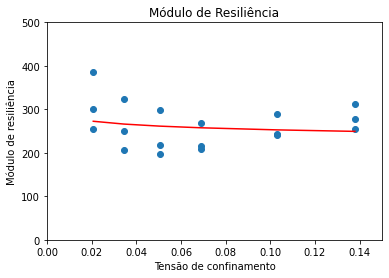

In [33]:
fig_s3 = plt.figure()
x = df.filter(items=['s3 (Mpa)'])
y = df.filter(items=['MR (Mpa)'])
y_pre = df.filter(items=['mr_s3_cal'])
plt.scatter(x, y, vmin=100)
plt.plot(x, y_pre, color='red')
plt.title('Módulo de Resiliência')
plt.xlabel('Tensão de confinamento')
plt.ylabel('Módulo de resiliência')
plt.xlim(0,0.15)
plt.ylim(0,500)
fig_s3_px = px.scatter(df, x='s3 (Mpa)', y='MR (Mpa)', labels={'MR (Mpa)':'MR (Mpa)'},
                        log_x=False, log_y=True,
                        range_x=None, range_y=[100, 1000],
                        title='Módulo de resiliêcia x Invariante de tensões')

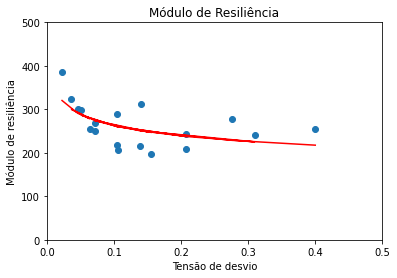

In [34]:
fig_sd = plt.figure()
x = df.filter(items=['sd (Mpa)'])
y = df.filter(items=['MR (Mpa)'])
y_pre = df.filter(items=['mr_sd_cal'])
plt.scatter(x, y, vmin=100)
plt.plot(x, y_pre, color='red')
plt.title('Módulo de Resiliência')
plt.xlabel('Tensão de desvio')
plt.ylabel('Módulo de resiliência')
plt.xlim(0, 0.5)
plt.ylim(0, 500)
fig_sd_px = px.scatter(df, x='sd (Mpa)', y='MR (Mpa)', labels={'MR (Mpa)':'MR (Mpa)'},                       
                        log_x=False, log_y=True,
                        range_x=None, range_y=[100, 1000],
                        title='Módulo de resiliêcia x Invariante de tensões')

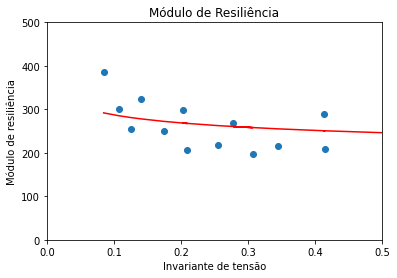

In [35]:
fig_oct = plt.figure()
x = df.filter(items=['oct (mpa)'])
y = df.filter(items=['MR (Mpa)'])
y_pre = df.filter(items=['mr_oct_cal'])
plt.scatter(x, y, vmin=100)
plt.plot(x, y_pre, color='red')
plt.title('Módulo de Resiliência')
plt.xlabel('Invariante de tensão')
plt.ylabel('Módulo de resiliência')
plt.xlim(0, 0.5)
plt.ylim(0, 500)
fig_oct_px = px.scatter(df,  x='oct (mpa)', y='MR (Mpa)', labels={'MR (Mpa)':'MR (Mpa)'},
                        log_x=False, log_y=True,
                        range_x=None, range_y=[100, 1000],
                        title='Módulo de resiliêcia x Invariante de tensões')

Métricas de avaliação dos modelos

In [36]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
mae_s3 = mean_absolute_error((df.iloc[:, 7].values), (df.iloc[:, 13].values))
msr_s3 = mean_squared_error((df.iloc[:, 7].values), (df.iloc[:, 13].values))
r2_s3 = r2_score((df.iloc[:, 7].values), (df.iloc[:, 13].values))
print(f'O modelo dependente de s3 tem o R² de {r2_s3:.2f}, o MAE de {mae_s3:.2f} e o MSR de {msr_s3:.2f}.')

O modelo dependente de s3 tem o R² de 0.04, o MAE de 38.44 e o MSR de 2159.78.


In [37]:
mae_sd = mean_absolute_error((df.iloc[:, 7].values), (df.iloc[:, 14].values))
msr_sd = mean_squared_error((df.iloc[:, 7].values), (df.iloc[:, 14].values))
r2_sd = r2_score((df.iloc[:, 7].values), (df.iloc[:, 14].values))
print(f'O modelo dependente de sd tem o R² de {r2_sd:.2f}, o MAE de {mae_sd:.2f} e o MSR de {msr_sd:.2f}.')

O modelo dependente de sd tem o R² de 0.41, o MAE de 31.82 e o MSR de 1335.72.


In [38]:
mae_oct = mean_absolute_error((df.iloc[:, 7].values), (df.iloc[:, 15].values))
msr_oct = mean_squared_error((df.iloc[:, 7].values), (df.iloc[:, 15].values))
r2_oct = r2_score((df.iloc[:, 7].values), (df.iloc[:, 15].values))
print(f'O modelo dependente de oct tem o R² de {r2_oct:.2f}, o MAE de {mae_oct:.2f} e o MSR de {msr_oct:.2f}.')

O modelo dependente de oct tem o R² de 0.16, o MAE de 36.45 e o MSR de 1885.62.


In [39]:
mae_comp = mean_absolute_error((df.iloc[:, 7].values), (df.iloc[:, 16].values))
msr_comp = mean_squared_error((df.iloc[:, 7].values), (df.iloc[:, 16].values))
r2_comp = r2_score((df.iloc[:, 7].values), (df.iloc[:, 16].values))
print(f'O modelo composto tem o R² de {r2_comp:.2f}, o MAE de {mae_comp:.2f} e o MSR de {mae_comp:.2f}.')

O modelo composto tem o R² de 0.63, o MAE de 24.80 e o MSR de 24.80.


Dashboard

In [40]:
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc

In [41]:
external_stylesheets = [dbc.themes.BOOTSTRAP]

In [42]:
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
app.title = 'Módulo de Resiliência'

In [43]:

colors = {
    'background': '#111111',
    'bodyColor':'#F2DFCE',
    'text': '#7FDBFF'
}
def get_page_heading_style():
    return {'backgroundColor': colors['background']}

def get_page_heading_title():
    return html.H1(children='Módulo de Resiliência', style={'textAlign': 'center', 'color': colors['text']})

def get_page_heading_subtitle():
    return html.Div(children='Cálculo de Modelos de Módulo de Resiliência para o MeDiNa',
                                         style={
                                             'textAlign':'center',
                                             'color':colors['text']
                                         })

def generate_page_header():
    main_header =  dbc.Row(
                            [
                                dbc.Col(get_page_heading_title(),md=12)
                            ],
                            align="center",
                            style=get_page_heading_style()
                        )
    subtitle_header = dbc.Row(
                            [
                                dbc.Col(get_page_heading_subtitle(),md=12)
                            ],
                            align="center",
                            style=get_page_heading_style()
                        )
    header = (main_header,subtitle_header)
    return header

In [44]:
def generate_table(dataframe, max_rows=10):
    return html.Table([
        html.Thead(
            html.Tr([html.Th(col) for col in dataframe.columns])
        ),
        html.Tbody([
            html.Tr([
                html.Td(f'{dataframe.iloc[i][col]:.4f}') for col in dataframe.columns
            ], className="table-text", style={'textAlign':'center',  'border': '1px solid', 'background-color':  'white'}) 
            for i in range(min(len(dataframe), max_rows))
        ])
    ])

In [45]:
def graph1():
    return dcc.Graph(id='graph1', figure=fig_s3_px)

In [46]:
def graph2():
    return dcc.Graph(id='graph2', figure=fig_sd_px)

In [47]:
def graph3():
    return dcc.Graph(id='graph3', figure=fig_oct_px)

In [48]:
def generate_card_content(card_header,card_value,overall_value):
    card_head_style = {'textAlign':'center','fontSize':'100%'}
    card_body_style = {'textAlign':'center','fontSize':'100%'}
    card_header = dbc.CardHeader(card_header,style=card_head_style)
    card_body = dbc.CardBody(
        [
            html.H5(f"{(card_value),}", className="card-title",style=card_body_style),
            html.P(
                "R²: {:,}".format(overall_value),
                className="card-text", style={'textAlign':'center'},
            ),
        ]
    )
    card = [card_header,card_body]
    return card

In [49]:
def generate_cards():

    cards = html.Div(
        [
            dbc.Row(
                [
                    dbc.Col(dbc.Card(generate_card_content("Modelo S3",eq_s3,score_s3), color="success", inverse=True),md=dict(size=3)),
                    dbc.Col(dbc.Card(generate_card_content("Modelo SD",eq_sd,score_sd), color="warning", inverse=True),md=dict(size=3)),
                    dbc.Col(dbc.Card(generate_card_content("Modelo OCT",eq_oct,score_oct),color="dark", inverse=True),md=dict(size=3)),
                    dbc.Col(dbc.Card(generate_card_content("Modelo COMP",eq_comp,score_comp),color="background", inverse=True),md=dict(size=3))
                ],
                className="mb-4",
            ),
        ],id='card1'
    )
    return cards

In [50]:
def generate_layout():
    page_header = generate_page_header()
    layout = dbc.Container(
        [
            page_header[0],
            page_header[1],
            html.Hr(),
            dbc.Row(
                [
                    dbc.Col(generate_table(df_result),md=dict(size=10, offset=3))
                ]
            ),
            html.Hr(),
            generate_cards(),
            html.Hr(),
            dbc.Row(
                [
                    dbc.Col(graph1(),md=dict(size=6, offset=3)),
                    dbc.Col(graph2(),md=dict(size=6, offset=3)),
                    dbc.Col(graph3(),md=dict(size=6, offset=3)),
                ],
                align="center",
            ),
        ], fluid=True,style={'backgroundColor': colors['bodyColor']}
    )
    return layout

In [51]:
app.layout = generate_layout()

In [ ]:
app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
